<a href="https://colab.research.google.com/github/sreesriavvaru123/MI/blob/main/MI_CNN_LSTM_v7_1.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Google Colab-compatible notebook for MI detection using PTB-XL with 12-leads and 10-fold CV



## STEP 1: Install necessary packages



In [14]:
!pip install wfdb scikit-learn matplotlib tensorflow --quiet


## STEP 2: Import required libraries


In [15]:
# CNN-LSTM with Stacking Decoding on PTB-XL (MI, Healthy, Other) - 12-lead Version
# Step 2: Imports
import os
import numpy as np
import pandas as pd
import wfdb
from tqdm import tqdm
from scipy.signal import savgol_filter, resample
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report, confusion_matrix, ConfusionMatrixDisplay
import matplotlib.pyplot as plt
import seaborn as sns
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv1D, MaxPooling1D, LSTM, Dense, Dropout, Flatten
from tensorflow.keras.utils import to_categorical
from tensorflow.keras.callbacks import EarlyStopping

## STEP 3: Download and unzip PTB-XL data

In [16]:
from google.colab import files
files.upload()  # Upload kaggle.json

!mkdir -p ~/.kaggle
!cp kaggle.json ~/.kaggle/
!chmod 600 ~/.kaggle/kaggle.json

# Install kaggle CLI if not already
!pip install -q kaggle

# Download the PTB-XL dataset
!kaggle datasets download -d khyeh0719/ptb-xl-dataset

# Unzip the dataset
!unzip ptb-xl-dataset.zip -d ptb-xl


Saving kaggle.json to kaggle (1).json
Dataset URL: https://www.kaggle.com/datasets/khyeh0719/ptb-xl-dataset
License(s): Attribution 4.0 International (CC BY 4.0)
ptb-xl-dataset.zip: Skipping, found more recently modified local copy (use --force to force download)
Archive:  ptb-xl-dataset.zip
replace ptb-xl/ptb-xl-a-large-publicly-available-electrocardiography-dataset-1.0.1/LICENSE.txt? [y]es, [n]o, [A]ll, [N]one, [r]ename: no
replace ptb-xl/ptb-xl-a-large-publicly-available-electrocardiography-dataset-1.0.1/RECORDS? [y]es, [n]o, [A]ll, [N]one, [r]ename: n
replace ptb-xl/ptb-xl-a-large-publicly-available-electrocardiography-dataset-1.0.1/SHA256SUMS.txt? [y]es, [n]o, [A]ll, [N]one, [r]ename: n
replace ptb-xl/ptb-xl-a-large-publicly-available-electrocardiography-dataset-1.0.1/example_physionet.py? [y]es, [n]o, [A]ll, [N]one, [r]ename: n
replace ptb-xl/ptb-xl-a-large-publicly-available-electrocardiography-dataset-1.0.1/ptbxl_database.csv? [y]es, [n]o, [A]ll, [N]one, [r]ename: n
replace ptb

## STEP 4: Load metadata and diagnostic class mapping

In [17]:
import pandas as pd

ptbxl_path = "/content/ptb-xl/ptb-xl-a-large-publicly-available-electrocardiography-dataset-1.0.1/"
print("Loading metadata...")

# Load metadata and SCP diagnostic info
df = pd.read_csv(ptbxl_path + 'ptbxl_database.csv')
class_map = pd.read_csv(ptbxl_path + 'scp_statements.csv', index_col=0)

# Add full path to 100Hz signal files
df['filename_lr'] = ptbxl_path + df['filename_lr']

# Evaluate stringified dict to real dict
df['scp_codes'] = df['scp_codes'].apply(eval)

# Apply 3-class mapping
df['class'] = df['scp_codes'].apply(lambda x: map_3_classes(x, class_map))

# Drop rows with unmapped class
df = df[df['class'].notnull()]

# Display class distribution
print("Class distribution:")
print(df['class'].value_counts())

# Final usable dataset
df_multiclass = df[['filename_lr', 'class']]


Loading metadata...
Class distribution:
class
NORM     9528
OTHER    6417
MI       5485
Name: count, dtype: int64


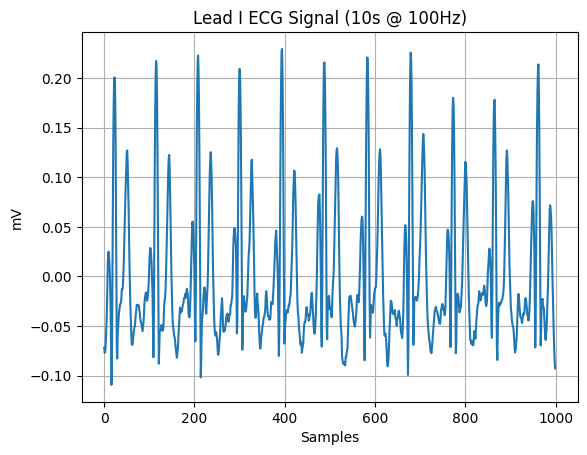

In [21]:
# Step 4: Signal Processing Function

def preprocess_ecg(record_path):
    record = wfdb.rdrecord(record_path)
    signal = record.p_signal.T  # Shape (12, 5000)

    # Denoising (per lead)
    signal_denoised = savgol_filter(signal, window_length=13, polyorder=3, axis=1)
    baseline = savgol_filter(signal_denoised, window_length=301, polyorder=4, axis=1)
    signal_clean = signal_denoised - baseline

    # Downsample from 500Hz to 250Hz
    # signal_downsampled = resample(signal_clean, 1000, axis=1)  # Direct to fixed 250Hz * 10s = 2500 samples
    return signal_clean

import matplotlib.pyplot as plt

test_ecg = preprocess_ecg(df_multiclass['filename_lr'].values[0].replace('.hea', ''))
plt.plot(test_ecg[0])  # Plot lead I
plt.title("Lead I ECG Signal (10s @ 100Hz)")
plt.xlabel("Samples")
plt.ylabel("mV")
plt.grid(True)
plt.show()

# Step 5: Create Dataset

def create_dataset(df, max_per_class=None):
    df = df.sample(frac=1, random_state=42).reset_index(drop=True)  # Shuffle
    X, y = [], []
    counts = {"MI": 0, "NORM": 0, "OTHER": 0}
    for idx, row in tqdm(df.iterrows(), total=len(df)):
        label = row["class"]
        if max_per_class and counts[label] >= max_per_class:
            continue
        path = row["filename_lr"].replace(".hea", "")  # Remove .hea extension
        try:
            ecg = preprocess_ecg(path)
            if ecg.shape != (12, 1000):
                print(f"Skipping {path} due to incorrect shape {ecg.shape}")
                continue
            X.append(ecg)
            y.append(["MI", "NORM", "OTHER"].index(label))
            counts[label] += 1
        except Exception as e:
            print(f"Error processing {path}: {e}")
            continue
    print("Final class counts:", counts)
    X = np.array(X)
    y = to_categorical(y, num_classes=3)
    print("X shape:", X.shape)
    print("y shape:", y.shape)
    return X, y


In [22]:
# Unbalanced
print("Creating unbalanced dataset...")
X_unbal, y_unbal = create_dataset(df_multiclass)

# Balanced
print("Creating balanced dataset...")
X_bal, y_bal = create_dataset(df_multiclass, max_per_class=1000)

Creating unbalanced dataset...


100%|██████████| 21430/21430 [04:41<00:00, 76.23it/s]


Final class counts: {'MI': 5485, 'NORM': 9528, 'OTHER': 6417}
X shape: (21430, 12, 1000)
y shape: (21430, 3)
Creating balanced dataset...


100%|██████████| 21430/21430 [00:42<00:00, 502.80it/s]  


Final class counts: {'MI': 1000, 'NORM': 1000, 'OTHER': 1000}
X shape: (3000, 12, 1000)
y shape: (3000, 3)


In [28]:
# First: Train+Val (80%) and Test (20%)
# Step 7: Split 60/20/20
X = np.transpose(X_unbal, (0, 2, 1))
y = y_unbal
X_temp, X_test, y_temp, y_test = train_test_split(X, y, test_size=0.2, stratify=y.argmax(axis=1), random_state=42)

# Then: Train (60%) and Val (20%)
X_train, X_val, y_train, y_val = train_test_split(X_temp, y_temp, test_size=0.25, stratify=y_temp.argmax(axis=1), random_state=42)

print("Train shape:", X_train.shape)
print("Validation shape:", X_val.shape)
print("Test shape:", X_test.shape)


Train shape: (12858, 1000, 12)
Validation shape: (4286, 1000, 12)
Test shape: (4286, 1000, 12)


In [29]:
# Step 8: CNN+LSTM Model

def create_cnn_lstm(input_shape):
    model = Sequential()
    model.add(Conv1D(64, kernel_size=3, activation='relu', input_shape=input_shape))
    model.add(MaxPooling1D(pool_size=2))
    model.add(Conv1D(128, kernel_size=3, activation='relu'))
    model.add(MaxPooling1D(pool_size=2))
    model.add(LSTM(64, return_sequences=False))
    model.add(Dropout(0.5))
    model.add(Dense(64, activation='relu'))
    model.add(Dense(3, activation='softmax'))
    model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])
    return model

model = create_cnn_lstm(X_train.shape[1:])
model.summary()

/usr/local/lib/python3.11/dist-packages/keras/src/layers/convolutional/base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Model: "sequential_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv1d_2 (Conv1D)               │ (None, 998, 64)        │         2,368 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling1d_2 (MaxPooling1D)  │ (None, 499, 64)        │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv1d_3 (Conv1D)               │ (None, 497, 128)       │        24,704 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling1d_3 (MaxPooling1D)  │ (None, 248, 128)       │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ lstm_1 (LSTM)                   │ (None, 64)             │        49,408 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_1 (Dropout)             │ (None, 64)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_2 (Dense)                 │ (None, 64)             │         4,160 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_3 (Dense)                 │ (None, 3)              │           195 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 80,835 (315.76 KB)

 Trainable params: 80,835 (315.76 KB)

 Non-trainable params: 0 (0.00 B)

In [30]:
# Step 9: Train Model

early_stop = EarlyStopping(monitor='val_loss', patience=10, restore_best_weights=True)
history = model.fit(
    X_train, y_train,
    validation_data=(X_val, y_val),
    epochs=50,
    batch_size=32,
    callbacks=[early_stop]
)

# Step 10: Evaluate
loss, acc = model.evaluate(X_test, y_test)
print("Test Accuracy:", acc)
print("Test Loss:", loss)

Epoch 1/50
402/402 ━━━━━━━━━━━━━━━━━━━━ 129s 310ms/step - accuracy: 0.5333 - loss: 0.9471 - val_accuracy: 0.6561 - val_loss: 0.7356
Epoch 2/50
402/402 ━━━━━━━━━━━━━━━━━━━━ 127s 316ms/step - accuracy: 0.6659 - loss: 0.7528 - val_accuracy: 0.6654 - val_loss: 0.7562
Epoch 3/50
402/402 ━━━━━━━━━━━━━━━━━━━━ 141s 315ms/step - accuracy: 0.7117 - loss: 0.6873 - val_accuracy: 0.7088 - val_loss: 0.6698
Epoch 4/50
402/402 ━━━━━━━━━━━━━━━━━━━━ 140s 309ms/step - accuracy: 0.7266 - loss: 0.6502 - val_accuracy: 0.7172 - val_loss: 0.6504
Epoch 5/50
402/402 ━━━━━━━━━━━━━━━━━━━━ 122s 305ms/step - accuracy: 0.7413 - loss: 0.6189 - val_accuracy: 0.7063 - val_loss: 0.6438
Epoch 6/50
402/402 ━━━━━━━━━━━━━━━━━━━━ 125s 311ms/step - accuracy: 0.7388 - loss: 0.6238 - val_accuracy: 0.7058 - val_loss: 0.6514
Epoch 7/50
402/402 ━━━━━━━━━━━━━━━━━━━━ 141s 308ms/step - accuracy: 0.7495 - loss: 0.6160 - val_accuracy: 0.7396 - val_loss: 0.6092
Epoch 8/50
402/402 ━━━━━━━━━━━━━━━━━━━━ 123s 305ms/step - accuracy: 0.7468 -

134/134 ━━━━━━━━━━━━━━━━━━━━ 15s 107ms/step
Classification Report:
              precision    recall  f1-score   support

          MI       0.77      0.64      0.70      1097
        NORM       0.81      0.90      0.85      1906
       OTHER       0.69      0.68      0.69      1283

    accuracy                           0.77      4286
   macro avg       0.76      0.74      0.75      4286
weighted avg       0.77      0.77      0.76      4286



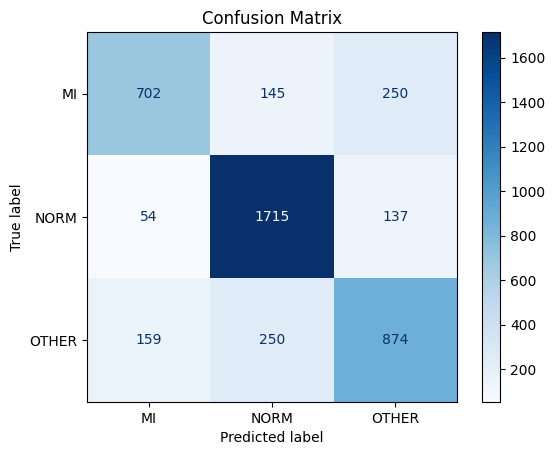

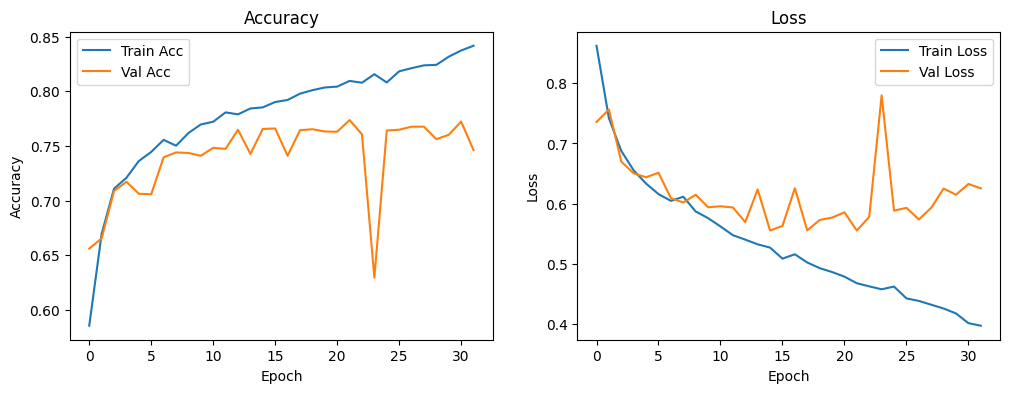

In [31]:
# Step 11: Classification Report
pred = model.predict(X_test)
y_pred = np.argmax(pred, axis=1)
y_true = np.argmax(y_test, axis=1)
print("Classification Report:")
print(classification_report(y_true, y_pred, target_names=["MI", "NORM", "OTHER"]))

# Step 12: Confusion Matrix
cm = confusion_matrix(y_true, y_pred)
ConfusionMatrixDisplay(cm, display_labels=["MI", "NORM", "OTHER"]).plot(cmap='Blues')
plt.title("Confusion Matrix")
plt.show()

# Step 13: Training Curves
plt.figure(figsize=(12, 4))
plt.subplot(1, 2, 1)
plt.plot(history.history['accuracy'], label='Train Acc')
plt.plot(history.history['val_accuracy'], label='Val Acc')
plt.title("Accuracy")
plt.xlabel("Epoch")
plt.ylabel("Accuracy")
plt.legend()

plt.subplot(1, 2, 2)
plt.plot(history.history['loss'], label='Train Loss')
plt.plot(history.history['val_loss'], label='Val Loss')
plt.title("Loss")
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.legend()
plt.show()
